# Product Invoice Classification

* Inv_ID (Invoice ID) : Unique number representing Invoice created by supplier/vendor

* Vendor Code (Vendor ID) : Unique number representing Vendor/Seller in the procurement system

* GL_Code: Account’s Reference ID

* Inv_Amt : Invoice Amount

* Item Description : Description of Item Purchased Example: “Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor”

* Product Category : Category of Product for which Invoice is raised A pseudo product category is represented in the dataset as CLASS-???, where ? is a digit.* 

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
# for saving the pipeline
import joblib

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline,make_union

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures

In [8]:
from sklearn.metrics import f1_score, roc_auc_score

In [9]:
from custom_functions import Mapper, Custom_Fillna, splitter
from custom_functions import find_pattern, get_date, get_date_features
from custom_functions import count_character, get_items_in_description, get_keywords_from_description
from custom_functions import my_train_test_split_with_balance

In [10]:
import json
import re
import itertools
import collections

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import seaborn as sns; sns.set_theme()

## Data

In [14]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')
sample_submission_data = pd.read_csv('sample_submission.csv')

## Transformations

In [15]:
## map for the target
tmp = train_data.groupby('Product_Category', as_index = False).agg(counts = ('Inv_Id','count')).sort_values('counts')
tmp['ranks'] = range(0,len(tmp))
map_target = dict(tmp[['Product_Category','ranks']].values)

In [16]:
#saving json
with open('map_target.json', 'w') as fp:
    json.dump(map_target, fp)

In [17]:
#loading json
with open('map_target.json', 'r') as fp:
    map_target = json.load(fp)

In [18]:
train_data['Map_Product_Category'] = train_data.Product_Category.map(map_target)

###  split data

In [19]:
seed = 12

In [20]:
initial_features = ['Inv_Id', 'Vendor_Code', 'GL_Code', 'Inv_Amt', 'Item_Description']
target = 'Map_Product_Category'

In [21]:
new_train, val_tmp  = my_train_test_split_with_balance(data = train_data, test_size = 0.3, n = 30, threshold = 70, seed = seed)

In [22]:
#def my_data_balance(data):

In [23]:
new_train.shape, val_tmp.shape

((5048, 8), (518, 8))

In [24]:
X_train, y_train, X_val, y_val  = new_train[initial_features], new_train[target] , val_tmp[initial_features], val_tmp[target]

### Pipeline

<b> Getting date finder regex

In [25]:
tmp_description = X_train[['Inv_Id','Item_Description']].copy()

In [26]:
lists_description_split = [x.split('/') for x in tmp_description.Item_Description.unique()]
lists_description_split = list(itertools.chain.from_iterable(lists_description_split))
lists_description_split = list(set(lists_description_split))
lists_description_split.sort()

In [27]:
month_3chr = '|'.join(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] )

In [28]:
month_rx = f'({month_3chr})'
year_rx = '\d{4}'

In [29]:
regexs_dates = [f'{month_rx}{year_rx}',f'{month_rx}-{year_rx}',f'{month_rx} {year_rx}',
        f'{year_rx}{month_rx}',f'{year_rx}-{month_rx}',f'{year_rx} {month_rx}',]
regexs_dates =  '|'.join(regexs_dates)

<b> regex for key words

In [30]:
key_words = ['Travel and Entertainment','Company Car','Corporate Services', 'Auto Leasing','General Contractor','Store Construction',
           'Ground Transportation','Base Rent','Final Site','Store Management','Site Clean Up', 'General Requirements', 'Real Estate','Media Buy',
           'Trade Show','Contingent Labor','Repair and Maintenance','Agency Fees','Human Resources','Manufacturing','Fortune National','Events and Promotions',
            'Laboratories', 'Artists & Models','National Advertising','Transportation Services',
           'Miscellaneous']
key_words_regex = '|'.join(key_words)

<b> regex for company type

In [31]:
type_company_regex = r'\b Co\b| Corp\b| Inc\b| Comp\b\b'

In [32]:
regex_to_use ={
    'dates_rx':regexs_dates,
    'month_rx':month_rx,
    'year_rx': year_rx,
    'keywords_rx':key_words_regex,
    'type_company_rx': type_company_regex
}

In [33]:
#saving json
with open('regex_to_use.json', 'w') as fp:
    json.dump(regex_to_use, fp)

In [34]:
#loading json
with open('regex_to_use.json', 'r') as fp:
    regex_to_use = json.load(fp)

<b> Other maps

In [35]:
def splitter_json(data):
    data[['TypeEnt','TypeEnt_number']] = data.Vendor_Code.str.split('-',expand=True)
    data[['GCL','GCL_number']] = data.GL_Code.str.split('-',expand=True)
    return data

In [36]:
## just to get the json
train_data = splitter_json(data = train_data).copy()
train_data_json = splitter_json(data = train_data)

In [37]:
def get_dictionary_rank1_tomap(data, variable):
    tmp = data.groupby([variable,'Map_Product_Category'], as_index = False).agg(counts = ('Inv_Id','count'))
    tmp["Rank"] = tmp.groupby([variable])["counts"].rank("dense", ascending=False)
    tmp = tmp[tmp.Rank == 1]
    map_rank =  dict(tmp[[variable,'Map_Product_Category']].values)
    return map_rank

In [38]:
TypeEnt_number_maps = get_dictionary_rank1_tomap(data = train_data_json, variable = 'TypeEnt_number')
del train_data_json

In [39]:
#saving json
with open('TypeEnt_number_maps.json', 'w') as fp:
    json.dump(TypeEnt_number_maps, fp)

In [40]:
#loading json
with open('TypeEnt_number_maps.json', 'r') as fp:
    TypeEnt_number_maps = json.load(fp)

<b> Additional

In [41]:
to_drop = ['Inv_Id','Vendor_Code','GL_Code', 'Item_Description']

#### The pipeline

In [42]:
feature_pipeline = Pipeline([
    
    ('NumberOfItemsInDescription_ready', ## clean not founds
     get_items_in_description(variables = ['Item_Description'], new_variable_names = ['ItemsInDescription'])
    ),
    
    ('GetKeyWord_prepro', ## needed to convert ordinal encoding and clean not founds
     get_keywords_from_description(variables = ['Item_Description','Item_Description'], new_variable_names = ['KeyWords','CompanyFoundType']
                                   , keywords = [regex_to_use['keywords_rx'], regex_to_use['type_company_rx']])
    ),
    
    ('TimeDate_features', ## needed to convert ordinal encoding and clean not founds
     get_date_features(variables = ['Item_Description'], date_regex = regex_to_use['dates_rx'],
                       year_regex = regex_to_use['year_rx'], moth_regex = regex_to_use['month_rx'])
    ),
    
    ('splitter',
     splitter(variables = ['Vendor_Code','GL_Code'], new_variable_names = ['TypeEnt_number','GCL_number'])
    ),
    
    ('cardinal-ordering',
     OrdinalEncoder(encoding_method='ordered', variables=['GCL_number','KeyWords','CompanyFoundType'])
    ),
    
    ('TypeEnt_number_map_modes', 
    Mapper(variables = ['TypeEnt_number'], mappings = TypeEnt_number_maps)
    ),
    
    ('drop_features',
     DropFeatures(features_to_drop= to_drop)
    ),
    
    ('Fill_na',
    Custom_Fillna(variables = ['TypeEnt_number','KeyWords','CompanyFoundType','YearFound','MonthFound'], fill_value = 0)
    )
])

### Modeling

<b> general settings

In [45]:
cv_seed = 1478
n_jobs_cv = -1

In [46]:
cv_setting = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = cv_seed )

<b> Knn

In [47]:
knn_parameters = {'onevsrestclassifier__estimator__n_neighbors': [2,3,4,5,6,7,8,9,10]}

In [48]:
knn_pipeline = make_pipeline(*feature_pipeline, OneVsRestClassifier(KNeighborsClassifier()))

In [49]:
%%time
knn_search =  GridSearchCV(knn_pipeline, param_grid = knn_parameters, cv = cv_setting, 
                           scoring = 'accuracy', n_jobs = n_jobs_cv, error_score="raise")
knn_search.fit(X_train, y_train)

Wall time: 1min 31s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1478, test_size=0.2, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('get_items_in_description',
                                        get_items_in_description(new_variable_names=['ItemsInDescription'],
                                                                 variables=['Item_Description'])),
                                       ('get_keywords_from_description',
                                        get_keywords_from_description(keywords=['Travel '
                                                                                'and '...
                                                                       'GL_Code',
                                                                       'Item_Description'])),
                                       ('custom_fillna',
                                        Custom_Fillna(fill_value=0,
                                           

In [50]:
knn_search.best_params_

{'onevsrestclassifier__estimator__n_neighbors': 3}

In [51]:
knn_search.best_score_

0.6748514851485148

<b> Gradien Boosting

In [56]:
gbc_parameters = {'onevsrestclassifier__estimator__learning_rate': [0.001,],
                  'onevsrestclassifier__estimator__max_depth': [5,7], 
                  'onevsrestclassifier__estimator__min_samples_split': [3, 5], 
                  'onevsrestclassifier__estimator__n_estimators': [200,250, 300],
                  'onevsrestclassifier__estimator__random_state':[seed]
                 }

In [57]:
gbc_pipeline = make_pipeline(*feature_pipeline, OneVsRestClassifier(GradientBoostingClassifier()))

In [58]:
%%time
gbc_search =  GridSearchCV(gbc_pipeline, param_grid = gbc_parameters, cv = cv_setting, 
                           scoring = 'accuracy', n_jobs = n_jobs_cv, error_score="raise")
gbc_search.fit(X_train, y_train)

Wall time: 24min 27s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1478, test_size=0.2, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('get_items_in_description',
                                        get_items_in_description(new_variable_names=['ItemsInDescription'],
                                                                 variables=['Item_Description'])),
                                       ('get_keywords_from_description',
                                        get_keywords_from_description(keywords=['Travel '
                                                                                'and '...
                                        OneVsRestClassifier(estimator=GradientBoostingClassifier()))]),
             n_jobs=-1,
             param_grid={'onevsrestclassifier__estimator__learning_rate': [0.001],
                         'onevsrestclassifier__estimator__max_depth': [5, 7],
                         'onevsrestclassifier__estimato

In [59]:
gbc_search.best_params_

{'onevsrestclassifier__estimator__learning_rate': 0.001,
 'onevsrestclassifier__estimator__max_depth': 7,
 'onevsrestclassifier__estimator__min_samples_split': 3,
 'onevsrestclassifier__estimator__n_estimators': 300,
 'onevsrestclassifier__estimator__random_state': 12}

In [60]:
gbc_search.best_score_

0.9774257425742574

#### Validation and model performance assessment

In [61]:
Labels = [map_target[key] for key in map_target.keys()]

<b> Knn

In [62]:
y_val_pred = knn_search.predict(X_val)

In [63]:
data_contrast = {
    'True': y_val,
    'Prediction': y_val_pred
}
data_contrast = pd.DataFrame(data_contrast).reset_index(drop = True).reset_index()

In [64]:
confusion_matrix = data_contrast.pivot_table(index = 'True', columns = 'Prediction', aggfunc = 'count', values= 'index').fillna(0)

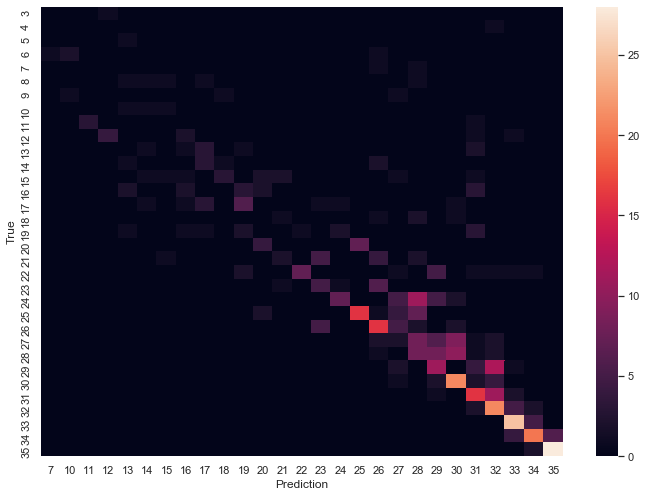

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(confusion_matrix)

<b> Gradient boosting 

In [66]:
y_val_pred = gbc_search.predict(X_val)

In [67]:
data_contrast = {
    'True': y_val,
    'Prediction': y_val_pred
}
data_contrast = pd.DataFrame(data_contrast).reset_index(drop = True).reset_index()

In [68]:
confusion_matrix = data_contrast.pivot_table(index = 'True', columns = 'Prediction', aggfunc = 'count', values= 'index').fillna(0)

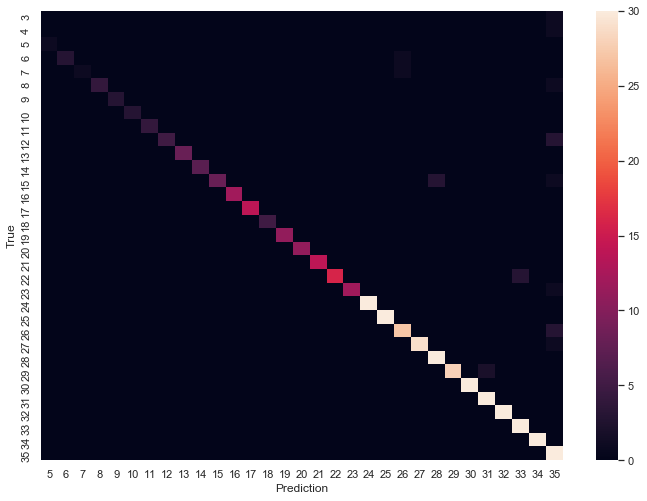

In [69]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(confusion_matrix)

In [85]:
gbc_probas = gbc_search.predict_proba(X_val)
knn_probas = knn_search.predict_proba(X_val)

gbc_roc_ = round(roc_auc_score(y_val, gbc_probas, multi_class='ovo', labels = Labels),4)
knn_roc_ = round(roc_auc_score(y_val, knn_probas, multi_class='ovo', labels = Labels),4)

In [86]:
print(f'the roc_auc score are: knn {knn_roc_} and gbc {gbc_roc_}')

the roc_auc score are: knn 0.8145 and gbc 0.9952


* the winner is the gradient boosing classifier

### Final Pipeline

In [43]:
gbc_parameters = {
    'learning_rate': 0.001,
    'max_depth': 7,
    'min_samples_split': 3,
    'n_estimators': 300,
    'random_state':seed,
}

In [44]:
#saving json
with open('gbc_parameters.json', 'w') as fp:
    json.dump(gbc_parameters, fp)

In [45]:
#loading json
with open('gbc_parameters.json', 'r') as fp:
    gbc_parameters = json.load(fp)

In [46]:
category_prediction_pipeline = make_pipeline(
    *feature_pipeline,
    OneVsRestClassifier(GradientBoostingClassifier(**gbc_parameters))
)

In [47]:
category_prediction_pipeline.fit(X_train, y_train)

Pipeline(steps=[('get_items_in_description',
                 get_items_in_description(new_variable_names=['ItemsInDescription'],
                                          variables=['Item_Description'])),
                ('get_keywords_from_description',
                 get_keywords_from_description(keywords=['Travel and '
                                                         'Entertainment|Company '
                                                         'Car|Corporate '
                                                         'Services|Auto '
                                                         'Leasing|General '
                                                         'Contractor|Store '
                                                         'Construction|Ground '
                                                         'Transportati...
                 DropFeatures(features_to_drop=['Inv_Id', 'Vendor_Code',
                                                'GL_Code',
    

<b> test data

In [48]:
X_test = test_data[initial_features]

In [92]:
y_test_pred = category_prediction_pipeline.predict(X_test)

In [93]:
y_test_pred.shape

(2446,)

In [94]:
X_test['yhat'] = y_test_pred

In [95]:
X_test.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,yhat
0,15003,VENDOR-2513,GL-6050310,56.13,Travel and Entertainment Miscellaneous Company...,35
1,15008,VENDOR-1044,GL-6101400,96.56,Final Site Clean Up Store Construction Advance...,33
2,15013,VENDOR-1254,GL-6101400,55.93,Arabian American Development Co Final Site Cle...,33
3,15019,VENDOR-1331,GL-2182000,32.62,Corporate Services Contingent Labor/Temp Labor...,31
4,15020,VENDOR-2513,GL-6050310,25.81,Fortune National Corp Miscellaneous Company Ca...,35


## saving machine

In [96]:
joblib.dump(category_prediction_pipeline, 'category_prediction_pipeline.joblib') 

['category_prediction_pipeline.joblib']